In [1]:
def random_forest_model(df, feat_to_drop, testing_size, feat_threshold=0):
    
    """
    about
    """
    """
    uses a built-in feature importance attribute that calculates feature importance scores for 
    each feature based on the quality of a node split in trees (gini)

    This can be used to determine what features might be able to be dropped from the model 
    
    Notes: 
    -feat_to_drop must include 'type'
    -Do not specify feat_threshold if you want to see feature importance scores
    """
    
    import warnings
    warnings.filterwarnings('ignore', '.*has feature names.*', )
    
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
    from sklearn.feature_selection import SelectFromModel
    import seaborn as sns
    
    X=df.drop(feat_to_drop, axis=1) #drop true classification from data along with features that are not important
    Y=df['type'].values #separate true classifications for fitting and evaluating the model

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = testing_size, random_state = 0)
    #split data into model training and model testing dataframes, random number seed of 0 
    
    rfc = RandomForestClassifier(criterion = 'gini', max_depth=None, random_state = 0) 
    
    """
    random state - set to either 0 or 42 is common, locks in the seed for a random number generator so 
    the same string of random numbers can be reproduced in the future. Used to create randomness in data selection
    and feature selection for each tree

    criterion - gini is default, entropy also used. Both are for classification. 

    reduce tree depth to simplify model and help with overfitting

    need to evaluate on training set - 100% on training is overfitting, low bias, high variance
    """
    
    rfc.fit(X_train, Y_train) #builds a forest of decision trees from the taining dataset 
   
    # For model with full features:
    if feat_threshold == 0: #39 sec to run with cat csv
        
        rfc_pred_train = rfc.predict(X_train) #predict classes for X using the fit 
        rfc_pred_test = rfc.predict(X_test)
        
        print("accuracy of model on training data =", rfc.score(X_train, Y_train)) # percent predictions that are correct
        print("accuracy of model on testing data =", rfc.score(X_test, Y_test))
        
        feature_importance = pd.Series(rfc.feature_importances_, index=X.columns).sort_values(ascending=True)
        #use full feature model to evaluate importance of features and rank them low to high
    
        print('Feature importances: ', rfc.feature_importances_) 
        #values of relative feature importance scores, useful for threshold determination
        
        print(sns.barplot(x=feature_importance, y=feature_importance.index)) #visualization of feature importance
        plt.xlabel('Feature Importance Score', fontsize=12)
        plt.ylabel('Features', fontsize=12)
        plt.title("Visualizing Important Features", fontsize=15, pad=15)
        plt.show()
          
        #printed confusion matrix and normalized confusion matrix as well as heat maps for both
        title_options = [("Confusion Matrix", None), ("Normalized Confusion Matrix", "true")] 
        types = df['type'].unique()
        
        for title, normalize in title_options:
            disp = ConfusionMatrixDisplay.from_estimator(rfc, X_test, Y_test, display_labels=types, include_values=False, 
                cmap=plt.cm.plasma, normalize=normalize, xticks_rotation='vertical')
            disp.ax_.set_title(title)

            print(title)
            print(disp.confusion_matrix)
            
    #for model with optimized features using a cutoff value (threshold) of feature importance scores, 
    #will not evaluate feature importance, go back to threshold of zero to see importance scores again   
    else: #105 sec to run with cat csv
        
        feature_selector = SelectFromModel(rfc, threshold = feat_threshold) 
        #removes features below threshold score
        
        important_features = feature_selector.fit_transform(X_train, Y_train) 
        test_imp_feat = feature_selector.fit_transform(X_test, Y_test)
        #update testing and training datasets to only include new set of features
        
        rfc2 = RandomForestClassifier(criterion = 'gini', max_depth=None, random_state = 0) 
        rfc2.fit(important_features, Y_train)
        #new rfc to train on new data

        rfc2_pred_train = rfc2.predict(important_features)
        rfc2_pred_test = rfc2.predict(test_imp_feat)
        
        print("accuracy of model on training data =", rfc2.score(important_features, Y_train)) 
        print("accuracy of model on testing data =", rfc2.score(test_imp_feat, Y_test))
        
        title_options = [("Confusion Matrix", None), ("Normalized Confusion Matrix", "true")] 
        types = df['type'].unique()
        
        for title, normalize in title_options:
            disp = ConfusionMatrixDisplay.from_estimator(rfc2, test_imp_feat, Y_test, display_labels=types, include_values=False, 
                cmap=plt.cm.plasma, normalize=normalize, xticks_rotation='vertical')
            disp.ax_.set_title(title)

            print(title)
            print(disp.confusion_matrix)
        

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('categorized_particles.csv')
df.type.values.reshape(-1, 1).shape

feat_to_drop = ['type','step','experiment']

accuracy of model on training data = 1.0
accuracy of model on testing data = 0.9962223578298899
Feature importances:  [0.20388491 0.00835873 0.04425944 0.00580464 0.02035178 0.02481053
 0.05473941 0.07283496 0.03284912 0.0330151  0.03896976 0.14631787
 0.04126707 0.25933925 0.00142805 0.00118604 0.0049462  0.00563715
 0.        ]
AxesSubplot(0.125,0.125;0.775x0.755)


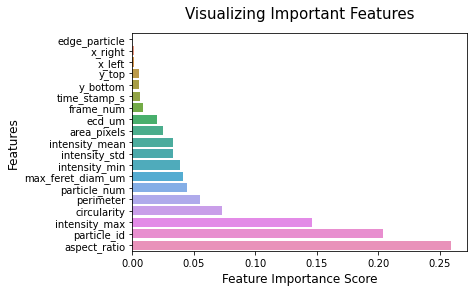

Confusion Matrix
[[    5     2     0     5     0     7     0     0     0     5     0     0]
 [    0 12533     0     3     0     1     0     5     0     0     0     0]
 [    0     3     1     0     0     0     0     1     0     1     0     0]
 [    0     1     0  1437     4     1     0     4     0     1     0     0]
 [    0     3     0    17   910     0     0    10     0     0     0     0]
 [    1     0     0     3     0   113     0     3     0     0     0     0]
 [    0     0     0     0     0     0   505     0     0     0     0     0]
 [    0     3     0     0    27     0     0 17392     0     0     0     0]
 [    0     0     0     0     5     1     0     6     0     1     0     0]
 [    1     0     0     0     0     0     0     0     0  1383     0     0]
 [    0     0     0     1     0     0     0     0     0     1     0     0]
 [    0     0     0     0     0     0     0     0     0     3     0     4]]
Normalized Confusion Matrix
[[2.08333333e-01 8.33333333e-02 0.00000000e+00 2.08333

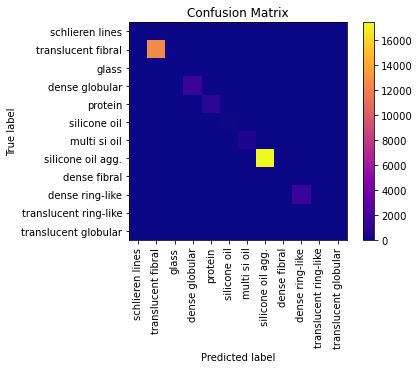

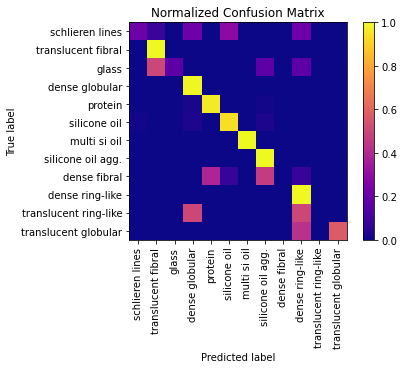

In [4]:
from timeit import default_timer as timer
start = timer()

random_forest_model(df, feat_to_drop, 0.3)

end = timer()
print("run time =",end - start," seconds")

accuracy of model on training data = 0.9999750918488075
accuracy of model on testing data = 0.991195187865051
Confusion Matrix
[[    1     2     0     6     0     3     0     0     0    11     0     1]
 [    2 12494     0     4     2     3     0    37     0     0     0     0]
 [    0     3     0     1     0     0     0     0     0     1     0     1]
 [    0    12     0  1421     5     0     0     5     0     4     0     1]
 [    0     3     0    12   913     1     0    11     0     0     0     0]
 [    0    25     0     6    17    65     0     4     0     3     0     0]
 [    0     0     0     0     0     0   503     0     0     2     0     0]
 [    0    56     0     6    26     2     0 17332     0     0     0     0]
 [    0     0     0     0     6     1     0     5     0     1     0     0]
 [    1     0     0     3     0     0     1     0     0  1378     0     1]
 [    0     0     0     1     0     0     0     0     0     1     0     0]
 [    0     0     0     1     0     0     0     

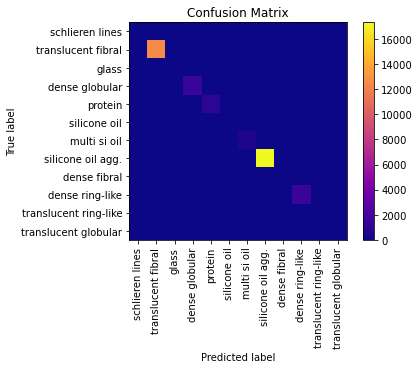

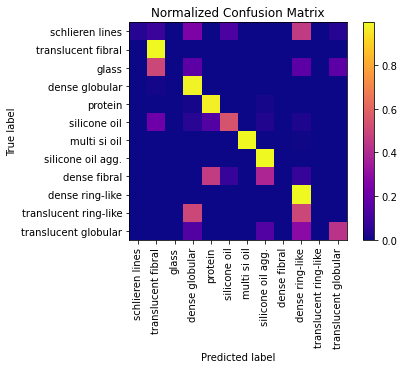

In [5]:
from timeit import default_timer as timer
start = timer()

random_forest_model(df, feat_to_drop, 0.3, 0.05)

end = timer()
print("run time =",end - start," seconds")

### Model from human catagorized data:

In [15]:
df_h = pd.read_csv('categorized_particles_101.csv')
df_h.type.values.reshape(-1, 1).shape

feat_to_drop = ['type','step','experiment','ml_type_proba','particle_id']

accuracy of model on training data = 1.0
accuracy of model on testing data = 0.8983364140480592
Feature importances:  [0.01945164 0.0442329  0.01374621 0.04025955 0.0462168  0.06122561
 0.05588793 0.109929   0.109462   0.07455222 0.10401016 0.0676346
 0.18673317 0.01332635 0.01410763 0.02089365 0.01833057 0.        ]
AxesSubplot(0.125,0.125;0.775x0.755)


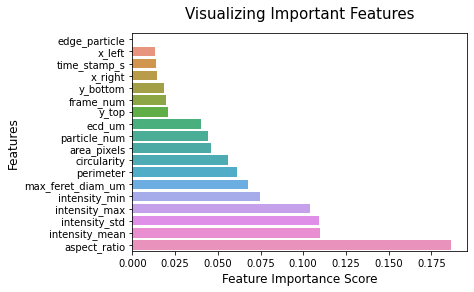

Confusion Matrix
[[  7   3   0   2   3   0   0   0   3   0   0]
 [  2 121   0   2   1   0   6   0   0   0   0]
 [  0   4   1   0   0   0   3   0   0   0   1]
 [  4   1   0  67   4   0   4   0   3   0   0]
 [  1   6   0   2 181   0   9   0   0   0   0]
 [  0   0   0   0   0 176   0   0   0   0   0]
 [  0   7   0   0  22   0 400   0   0   0   0]
 [  0   0   0   0   6   0   4   0   1   0   0]
 [  2   0   0   0   0   0   0   0  13   0   1]
 [  0   0   0   0   0   0   0   0   2   0   0]
 [  0   0   0   0   0   0   0   0   1   0   6]]
Normalized Confusion Matrix
[[0.38888889 0.16666667 0.         0.11111111 0.16666667 0.
  0.         0.         0.16666667 0.         0.        ]
 [0.01515152 0.91666667 0.         0.01515152 0.00757576 0.
  0.04545455 0.         0.         0.         0.        ]
 [0.         0.44444444 0.11111111 0.         0.         0.
  0.33333333 0.         0.         0.         0.11111111]
 [0.04819277 0.01204819 0.         0.80722892 0.04819277 0.
  0.04819277 0.        

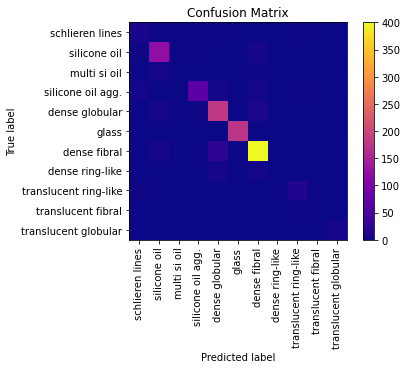

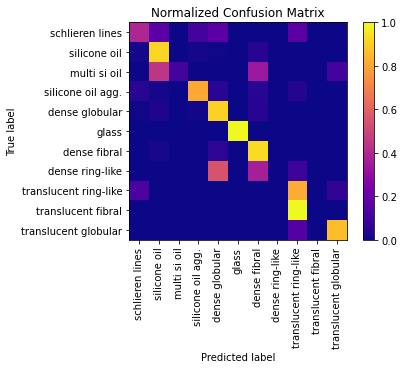

In [16]:
from timeit import default_timer as timer
start = timer()

random_forest_model(df_h, feat_to_drop, 0.3)

end = timer()
print("run time =",end - start," seconds")

accuracy of model on training data = 1.0
accuracy of model on testing data = 0.890018484288355
Confusion Matrix
[[  6   3   0   1   3   0   0   0   3   1   1]
 [  0 122   0   3   1   0   6   0   0   0   0]
 [  0   4   2   0   0   0   2   0   0   0   1]
 [  4   0   0  62   8   0   6   0   3   0   0]
 [  1   8   0   4 175   0  11   0   0   0   0]
 [  0   0   0   0   0 176   0   0   0   0   0]
 [  0   7   0   0  19   0 403   0   0   0   0]
 [  1   1   0   1   3   0   3   1   1   0   0]
 [  3   0   0   0   0   0   0   0  11   0   2]
 [  0   0   0   0   0   1   0   0   1   0   0]
 [  0   0   1   0   0   1   0   0   0   0   5]]
Normalized Confusion Matrix
[[0.33333333 0.16666667 0.         0.05555556 0.16666667 0.
  0.         0.         0.16666667 0.05555556 0.05555556]
 [0.         0.92424242 0.         0.02272727 0.00757576 0.
  0.04545455 0.         0.         0.         0.        ]
 [0.         0.44444444 0.22222222 0.         0.         0.
  0.22222222 0.         0.         0.         

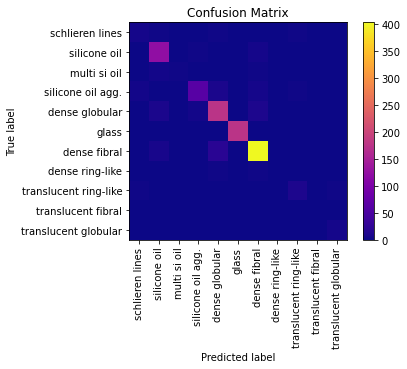

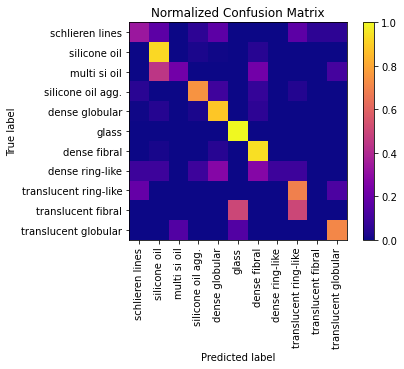

In [17]:
from timeit import default_timer as timer
start = timer()

random_forest_model(df_h, feat_to_drop, 0.3, 0.05)

end = timer()
print("run time =",end - start," seconds")

In [6]:
#function to test a previous model on new data